# Barotropic Kinetic Energy Fraction

Computes the barotropic kinetic energy fraction for a set of four CESM2-MOM6 simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)

def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])



fs = 15

alpha_res = 2.
p_res = 50

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='04:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:40021,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time
res_funcs = []

for i in range(num_sims):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    #sim.open_all_files(sim.native_path)
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()

    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 1min 5s, sys: 6.14 s, total: 1min 11s
Wall time: 2min 53s


In [6]:
%%time
sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sim.open_files_by_year(sim.ocn_data_path, sim.z_end, start_year, end_year)
    sim.open_grid()
    sims.append(sim)

Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
CPU times: user 26.8 s, sys: 2.31 s, total: 29.1 s
Wall time: 48.6 s


### Compute the barotropic energy fraction

In [7]:
deg2rad, Re = np.pi/180.0, 6_370_000.0  


# ---------------------------------------------------------------------
# 1) barotropic-energy fraction on the model grid
# ---------------------------------------------------------------------
def compute_kebt_frac(self,
                      start_date, end_date,
                      vertical_coordinate='zl'):
    """
    Barotropic-kinetic-energy fraction  KE_bt / KE_tot   (time-mean).

    The depth averages are weighted by true layer thickness Δz and
    restricted to wet cells within the model topography.

    Returns
    -------
    xr.DataArray (yh,xh)   name='kebt_frac'
    """
    if self.ds_type != self.z_mode:
        raise ValueError("Can only compute kebt_frac with z coordinates.")

    ds = self.ds.sel(time=slice(start_date, end_date))

    # ------------------------------------------------------------------
    # 1. build Δz(zl) and a time-independent water mask
    # ------------------------------------------------------------------
    # layer thickness from interface depths
    dz_iface = ds[vertical_coordinate].diff(vertical_coordinate)
    dz = dz_iface.pad({vertical_coordinate: (0, 1)},
                      constant_values=dz_iface.isel(**{vertical_coordinate: -1}))
    dz = dz.assign_coords({vertical_coordinate: ds[vertical_coordinate]})

    wet3d = ds['wet'] == 1                                       # (time,zl,yh,xh)
    topo3d = xr.broadcast(ds[vertical_coordinate],               # (zl) → (zl,yh,xh)
                          ds['depth_ocean'])[1]

    water_mask = wet3d.isel(time=0) & (ds[vertical_coordinate] < topo3d)
    dz_wat = dz.where(water_mask)                                # (zl,yh,xh)

    H = dz_wat.sum(dim=vertical_coordinate)                      # total depth (yh,xh)

    # ------------------------------------------------------------------
    # 2. interpolate velocities onto T-points
    # ------------------------------------------------------------------
    uo = ds.uo.interp(xq=ds.h.xh, method='linear').drop_vars('xq')
    vo = ds.vo.interp(yq=ds.h.yh, method='linear').drop_vars('yq')

    # broadcast dz_wat to match time dimension automatically
    # ------------------------------------------------------------------
    # 3. barotropic velocity (thickness-weighted depth mean)
    # ------------------------------------------------------------------
    u_bt = (uo * dz_wat).sum(dim=vertical_coordinate) / H
    v_bt = (vo * dz_wat).sum(dim=vertical_coordinate) / H

    KE_bt = 0.5*(u_bt**2 + v_bt**2).mean(dim='time')             # time mean

    # ------------------------------------------------------------------
    # 4. total KE (thickness-weighted)
    # ------------------------------------------------------------------
    KE_3d = 0.5*(uo**2 + vo**2)
    KE_tot = ((KE_3d * dz_wat).sum(dim=vertical_coordinate) / H).mean(dim='time')

    kebt_frac = (KE_bt / KE_tot).rename('kebt_frac')

    # use your stored horizontal coords so plots line up
    kebt_frac = kebt_frac.assign_coords({
        'geolon': self.grid['geolon'],
        'geolat': self.grid['geolat']
    })

    return kebt_frac.compute()


# ---------------------------------------------------------------------
# 2) zonal (longitude) mean of that fraction
# ---------------------------------------------------------------------
def compute_kebt_frac_zonal(self,
                            start_date, end_date,
                            kebt_frac=None):
    """
    Wet-masked *equal-weight* zonal mean of kebt_frac
    (same logic you used in the slope routine).
    """
    if self.ds_type != self.z_mode:
        raise ValueError("Can only compute kebt_frac_zonal with z coordinates.")

    if kebt_frac is None:
        kebt_frac = self.compute_kebt_frac(start_date, end_date)

    # 2-D wet mask (yh,xh) – take first time slice for speed
    wet2d = (self.ds['wet'].isel(time=0) == 1).astype(float)

    kebt_frac_zonal = (kebt_frac * wet2d).sum(dim='xh') / wet2d.sum(dim='xh')
    kebt_frac_zonal = kebt_frac_zonal.rename('kebt_frac_zonal')

    return kebt_frac_zonal.compute()

In [8]:
%%time
fracs = []
zonals = []
for i in tqdm(range(num_sims)):
    sim = sims[i]
    sim.ds_type = sim.z_mode
    kebt_frac = sim.compute_kebt_frac(start_date,end_date)
    fracs.append(kebt_frac)
    kebt_frac_zonal = sim.compute_kebt_frac_zonal(start_date,end_date,kebt_frac=kebt_frac)
    zonals.append(kebt_frac_zonal)

100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

CPU times: user 1.93 s, sys: 15.5 ms, total: 1.95 s
Wall time: 2.12 s


### Zonally integrated barotropic kinetic energy fraction

In [9]:
save_path = 'png/'

In [ ]:
%%time
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale
labels = snames

plt.figure(figsize=(4,6))

ax = plt.subplot(111)

lw=3
for i in tqdm(range(num_sims)):
    ax.plot(zonals[i],sims[i].ds.yh,c=c[i],lw=lw,label=labels[i])

ax.set_ylim([-60,60])
ax.set_xlim([0,1])
#ax.grid()
ax.set_ylabel('Latitude')
ax.set_xlabel('Fraction')
title = 'Barotropic KE fraction'
ax.set_title(title)  
ax.legend()

plt.savefig(save_path+title+'.png',dpi=300)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [09:50<00:00, 147.63s/it]


CPU times: user 48.2 s, sys: 3.66 s, total: 51.9 s
Wall time: 9min 50s


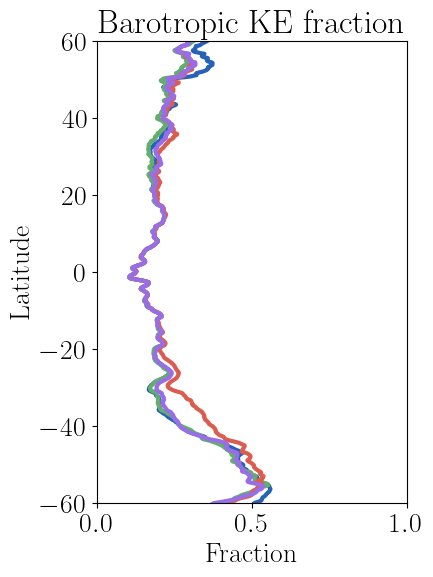

In [11]:
%%time
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale
labels = snames

plt.figure(figsize=(4,6))

ax = plt.subplot(111)

lw=3
for i in tqdm(range(num_sims)):
    ax.plot(zonals[i],sims[i].ds.yh,c=c[i],lw=lw,label=labels[i])

ax.set_ylim([-60,60])
ax.set_xlim([0,1])
#ax.grid()
ax.set_ylabel('Latitude')
ax.set_xlabel('Fraction')
title = 'Barotropic KE fraction'
ax.set_title(title)  
#ax.legend()

plt.savefig(save_path+title+'no_legend.png',dpi=300)

### Differences in barotropic kinetic energy fraction between simulations and reference

In [12]:
%%time
diffs = []
for i in tqdm(range(1,num_sims)):
    diff = fracs[i].fillna(0)-fracs[0].fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)
    diffs.append(diff)

100%|██████████| 3/3 [00:00<00:00,  7.44it/s]

CPU times: user 169 ms, sys: 62.9 ms, total: 232 ms
Wall time: 406 ms


CPU times: user 1min 54s, sys: 5.9 s, total: 2min
Wall time: 15min 29s


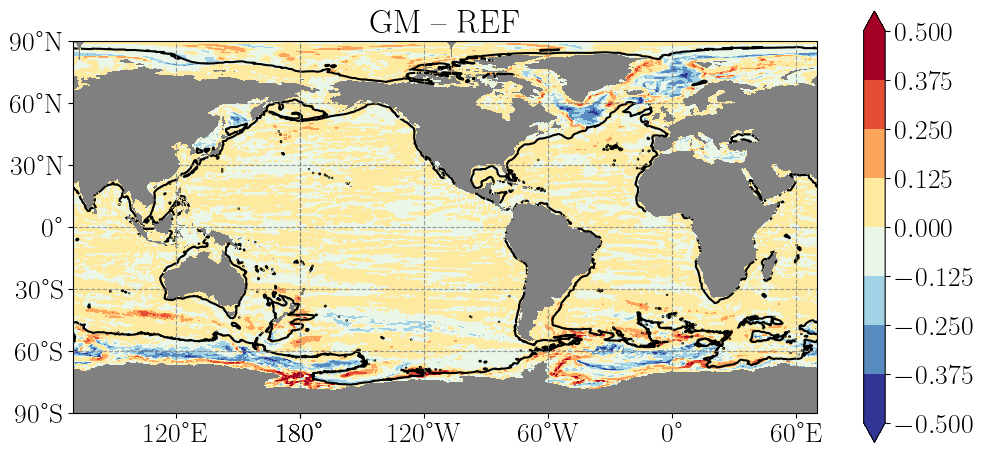

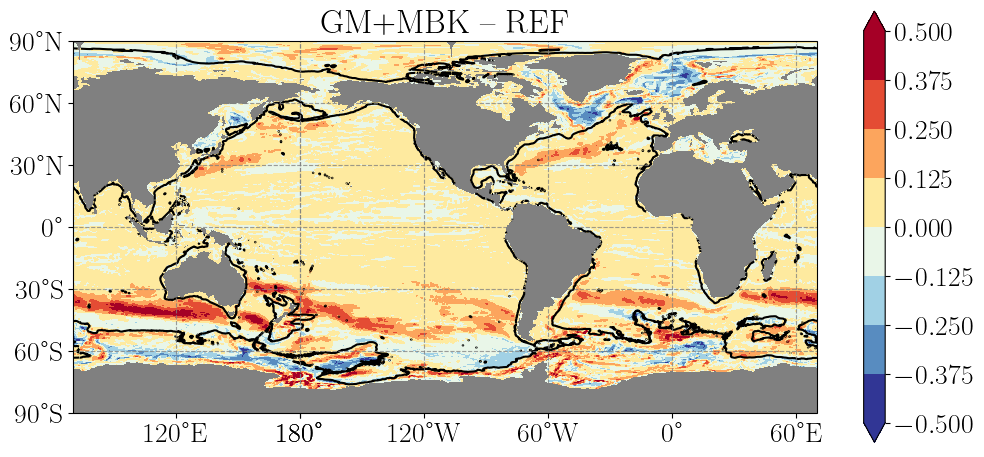

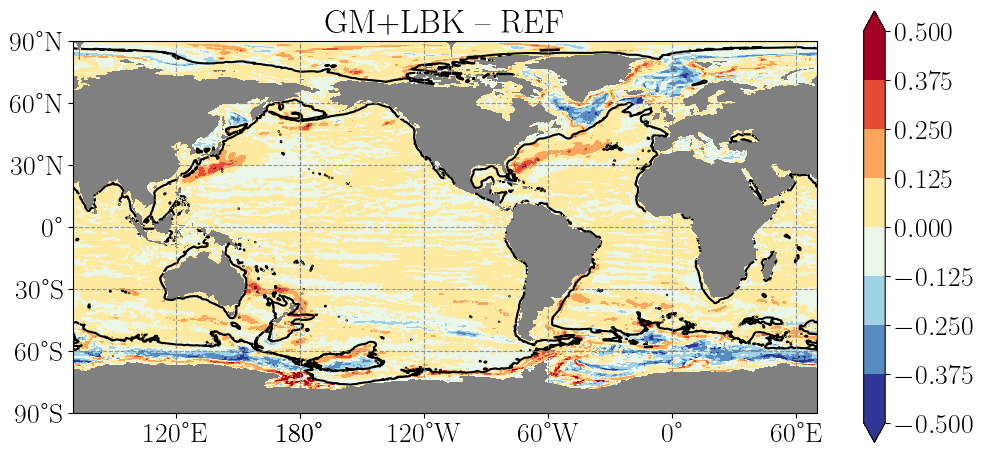

In [13]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -0.5, 0.5
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']

for sim, sname, R, diff in zip(sims[1:], snames[1:], res_funcs[1:], diffs):
    title = sname + ' – REF'
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+title+'global.png',dpi=300)

### Barotropic kinetic energy fraction in reference simulation

CPU times: user 20.1 s, sys: 1.14 s, total: 21.3 s
Wall time: 2min 39s


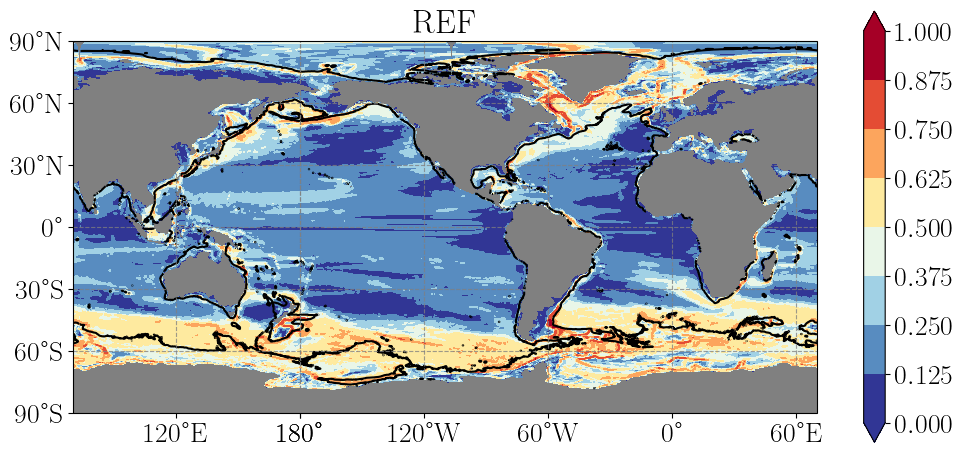

In [15]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 1
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']

sim = sims[0]
sname = snames[0]
R = res_funcs[0]


title = sname
# pass norm instead of vmin/vmax
mappable = sim.plot_global_discrete(fracs[0],
                                    cmap=cmap,
                                    levels=levels,
                                    cbar_label= r'',
                                    title=title,
                                    figsize=(12,8),
                                    R=R,
                                    R_threshold=0.5,
                                    contour_color='k', 
                                    contour_linewidth=1.5, 
                                    contour_linestyle='-')

ax = plt.gca()

# set up graticules
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
plt.savefig(save_path+title+'global.png',dpi=300)